In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dists
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal
from anesthetic.plot import kde_plot_1d, kde_contour_plot_2d
from torch_utils import get_limits, visualise_tension, visualise_coordinate
from np_utils import simple_data, curved_data, uniform_prior_samples
from tension_net import TensionNet, TensionNet1
from tension_quantify import BayesFactor, SuspiciousnessKLDiv, LogSuspiciousness

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
X0, X1, X_prior = simple_data()
X0_tensor = torch.tensor(X0).float().to(device)
X1_tensor = torch.tensor(X1).float().to(device)
X_prior_tensor = torch.tensor(X_prior).float().to(device)

(<matplotlib.tri.tricontour.TriContourSet at 0x7fd9f54aeee0>,
 <matplotlib.tri.tricontour.TriContourSet at 0x7fd9f558d4c0>)

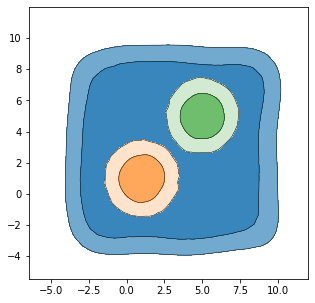

In [4]:
fig, axs = plt.subplots(figsize=(5, 5))

kde_contour_plot_2d(axs, X_prior[:, 0], X_prior[:, 1])
kde_contour_plot_2d(axs, X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs, X1[:, 0], X1[:, 1])

In [60]:
tension_R = TensionNet1(2).to(device)
criterion = BayesFactor(hist_type="gaussian", hist_param=1, n_dist_bins=100, 
                        n_prior_bins=50).to(device)
optimizer = optim.SGD(tension_R.parameters(), lr=0.0005)

losses_R = []

for i in range(2000):
    optimizer.zero_grad()
    X0_1d = tension_R(X0_tensor)
    X1_1d = tension_R(X1_tensor)
    X_prior_1d = tension_R(X_prior_tensor)

    loss = criterion(X0_1d, X1_1d, X_prior_1d)
    losses_R.append(loss.item())
    loss.backward()
    optimizer.step()

In [61]:
tension_S = TensionNet1(2).to(device)
criterion = SuspiciousnessKLDiv(hist_type="gaussian", hist_param=1,
                                n_dist_bins=100, n_prior_bins=50).to(device)
optimizer = optim.SGD(tension_S.parameters(), lr=0.0005)

losses_S = []
for i in range(2000):
    optimizer.zero_grad()
    X0_1d = tension_S(X0_tensor)
    X1_1d = tension_S(X1_tensor)
    X_prior_1d = tension_S(X_prior_tensor)

    loss = criterion(X0_1d, X1_1d, X_prior_1d)
    losses_S.append(loss.item())
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Text(0.5, 1.0, 'Marginalised 1d distribution')

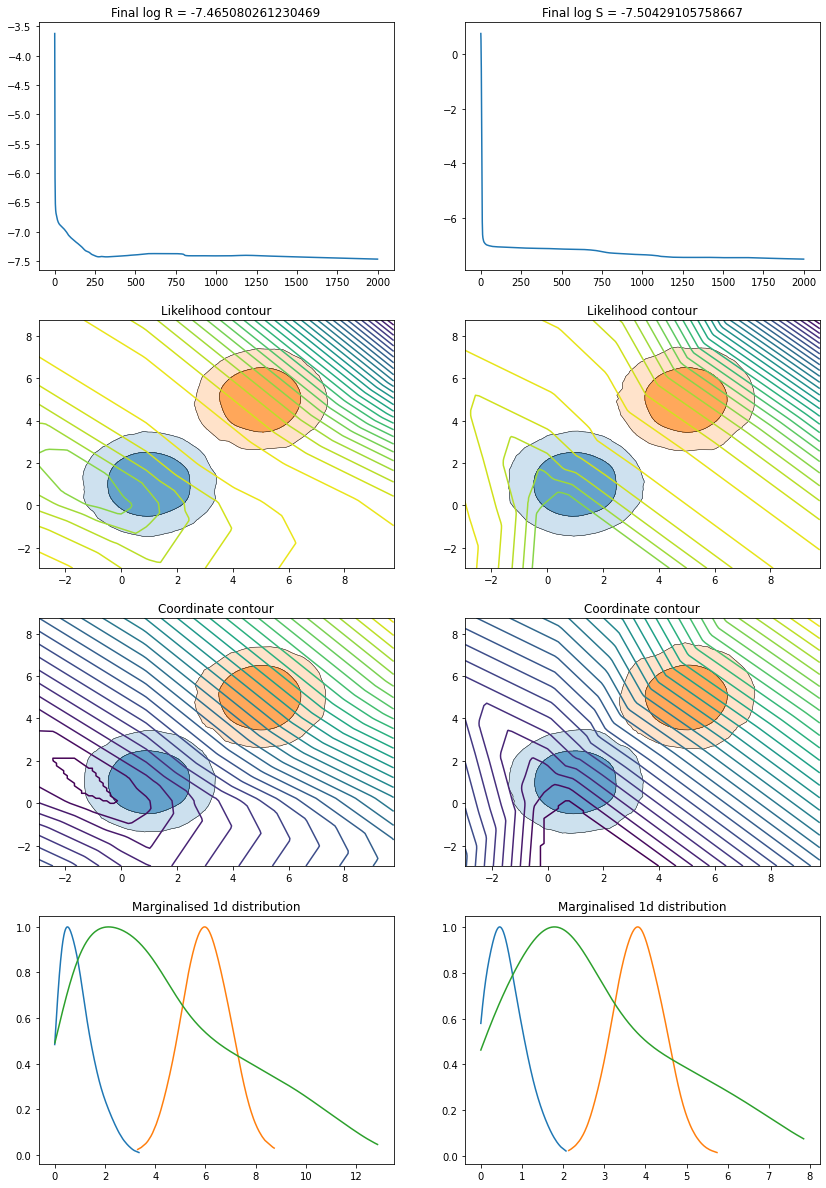

In [62]:
fig, axs = plt.subplots(4, 2, figsize=(14, 21))

axs[0, 0].plot(np.arange(2000), losses_R)
axs[0, 0].set_title(f"Final log R = {losses_R[-1]}")
X0_1d_R = tension_R(X0_tensor)
X1_1d_R = tension_R(X1_tensor)
X_prior_1d_R = tension_R(X_prior_tensor)
tension_R.to(torch.device("cpu"))
visualise_tension(fig, axs[1, 0], tension_R, X0, X1)
axs[1, 0].set_title("Likelihood contour")
visualise_coordinate(fig, axs[2, 0], tension_R, X0, X1)
axs[2, 0].set_title("Coordinate contour")
kde_plot_1d(axs[3, 0], X0_1d_R.squeeze().cpu().detach().numpy())
kde_plot_1d(axs[3, 0], X1_1d_R.squeeze().cpu().detach().numpy())
kde_plot_1d(axs[3, 0], X_prior_1d_R.squeeze().cpu().detach().numpy())
axs[3, 0].set_title("Marginalised 1d distribution")

axs[0, 1].plot(np.arange(2000), losses_S)
axs[0, 1].set_title(f"Final log S = {losses_S[-1]}")
X0_1d_S = tension_S(X0_tensor)
X1_1d_S = tension_S(X1_tensor)
X_prior_1d_S = tension_S(X_prior_tensor)
tension_S.to(torch.device("cpu"))
visualise_tension(fig, axs[1, 1], tension_S, X0, X1)
axs[1, 1].set_title("Likelihood contour")
visualise_coordinate(fig, axs[2, 1], tension_S, X0, X1)
axs[2, 1].set_title("Coordinate contour")
kde_plot_1d(axs[3, 1], X0_1d_S.squeeze().cpu().detach().numpy())
kde_plot_1d(axs[3, 1], X1_1d_S.squeeze().cpu().detach().numpy())
kde_plot_1d(axs[3, 1], X_prior_1d_S.squeeze().cpu().detach().numpy())
axs[3, 1].set_title("Marginalised 1d distribution")

In [43]:
X0_c, X1_c, X_prior_c = curved_data()
X0_c_tensor = torch.tensor(X0_c).float().to(device)
X1_c_tensor = torch.tensor(X1_c).float().to(device)
X_prior_c_tensor = torch.tensor(X_prior_c).float().to(device)

/content/drive/MyDrive/project/np_utils.py:33: RuntimeWarning: covariance is not positive-semidefinite.
  X1 = np.concatenate((X1, np.random.multivariate_normal(mu, Sigma1, size=(int(size / 5)))))


(<matplotlib.tri.tricontour.TriContourSet at 0x7f6f6812ccc0>,
 <matplotlib.tri.tricontour.TriContourSet at 0x7f6f680a1ef0>)

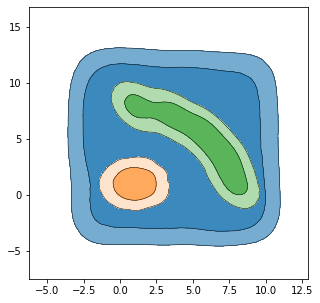

In [44]:
fig, axs = plt.subplots(figsize=(5, 5))

kde_contour_plot_2d(axs, X_prior_c[:, 0], X_prior_c[:, 1])
kde_contour_plot_2d(axs, X0_c[:, 0], X0_c[:, 1])
kde_contour_plot_2d(axs, X1_c[:, 0], X1_c[:, 1])

In [45]:
tension_R = TensionNet1(2).to(device)
criterion = BayesFactor(hist_type="gaussian", hist_param=1, 
                        n_dist_bins=100, n_prior_bins=50).to(device)
optimizer = optim.SGD(tension_R.parameters(), lr=0.001)

losses_R = []
for i in range(2000):
    optimizer.zero_grad()
    X0_1d = tension_R(X0_c_tensor)
    X1_1d = tension_R(X1_c_tensor)
    X_prior_1d = tension_R(X_prior_c_tensor)
    
    loss = criterion(X0_1d, X1_1d, X_prior_1d)
    losses_R.append(loss.item())
    loss.backward()
    optimizer.step()

In [48]:
tension_S = TensionNet1(2).to(device)
criterion = SuspiciousnessKLDiv(hist_type="gaussian", hist_param=1,
                                n_dist_bins=100, n_prior_bins=50).to(device)
optimizer = optim.SGD(tension_S.parameters(), lr=0.001)

losses_S = []
for i in range(2000):
    optimizer.zero_grad()
    X0_1d = tension_S(X0_c_tensor)
    X1_1d = tension_S(X1_c_tensor)
    X_prior_1d = tension_S(X_prior_c_tensor)
    
    loss = criterion(X0_1d, X1_1d, X_prior_1d)
    losses_S.append(loss.item())
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Text(0.5, 1.0, 'Marginalised 1d distribution')

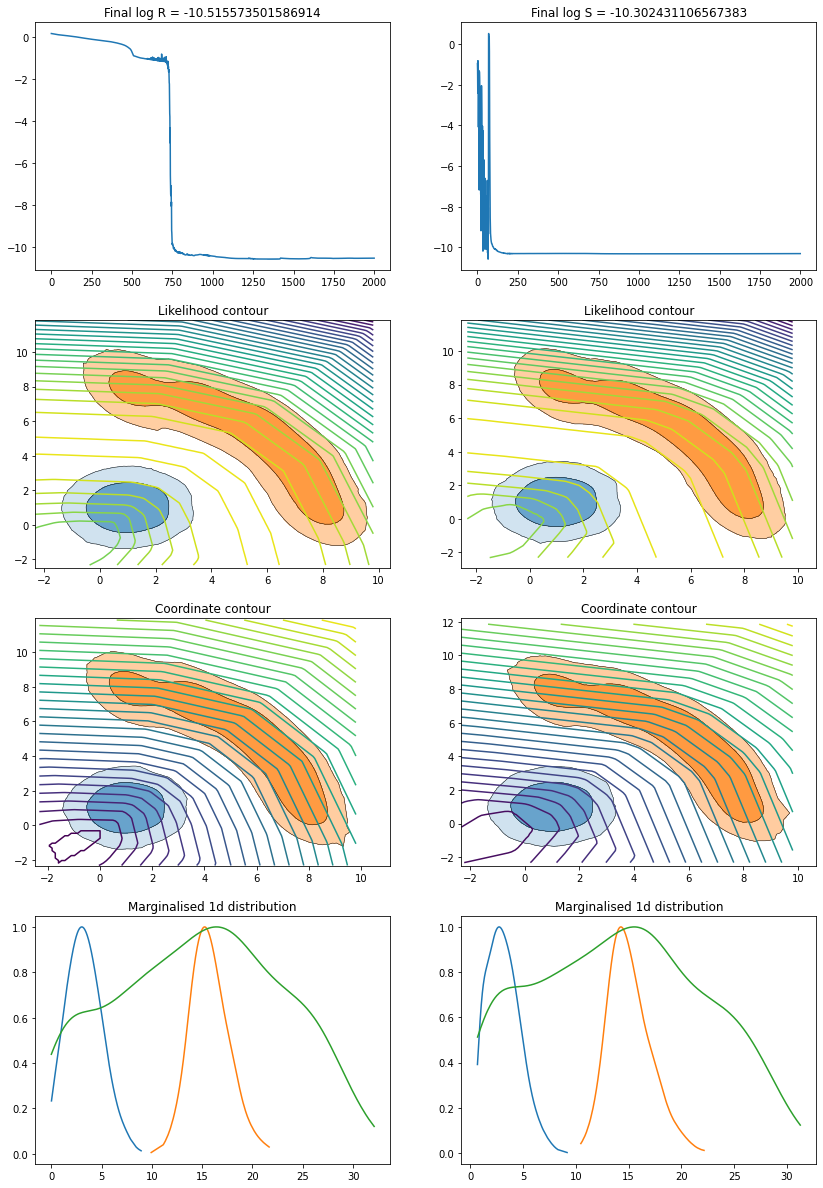

In [51]:
fig, axs = plt.subplots(4, 2, figsize=(14, 21))

axs[0, 0].plot(np.arange(2000), losses_R)
axs[0, 0].set_title(f"Final log R = {losses_R[-1]}")
X0_c_1d_R = tension_R(X0_c_tensor)
X1_c_1d_R = tension_R(X1_c_tensor)
X_prior_c_1d_R = tension_R(X_prior_c_tensor)
tension_R.to(torch.device("cpu"))
visualise_tension(fig, axs[1, 0], tension_R, X0_c, X1_c)
axs[1, 0].set_title("Likelihood contour")
visualise_coordinate(fig, axs[2, 0], tension_R, X0_c, X1_c)
axs[2, 0].set_title("Coordinate contour")
kde_plot_1d(axs[3, 0], X0_c_1d_R.squeeze().cpu().detach().numpy())
kde_plot_1d(axs[3, 0], X1_c_1d_R.squeeze().cpu().detach().numpy())
kde_plot_1d(axs[3, 0], X_prior_c_1d_R.squeeze().cpu().detach().numpy())
axs[3, 0].set_title("Marginalised 1d distribution")

axs[0, 1].plot(np.arange(2000), losses_S)
axs[0, 1].set_title(f"Final log S = {losses_S[-1]}")
X0_c_1d_S = tension_S(X0_c_tensor)
X1_c_1d_S = tension_S(X1_c_tensor)
X_prior_c_1d_S = tension_S(X_prior_c_tensor)
tension_S.to(torch.device("cpu"))
visualise_tension(fig, axs[1, 1], tension_S, X0_c, X1_c)
axs[1, 1].set_title("Likelihood contour")
visualise_coordinate(fig, axs[2, 1], tension_S, X0_c, X1_c)
axs[2, 1].set_title("Coordinate contour")
kde_plot_1d(axs[3, 1], X0_c_1d_S.squeeze().cpu().detach().numpy())
kde_plot_1d(axs[3, 1], X1_c_1d_S.squeeze().cpu().detach().numpy())
kde_plot_1d(axs[3, 1], X_prior_c_1d_S.squeeze().cpu().detach().numpy())
axs[3, 1].set_title("Marginalised 1d distribution")
